In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from get_anomaly_scores import get_anomaly_scores

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R -w 5 -h 5 --units in -r 200

library("stlplus")
# load data
temp_data <- read.csv(file="data/daily-minimum-temperatures-in-me.csv", stringsAsFactors=FALSE)

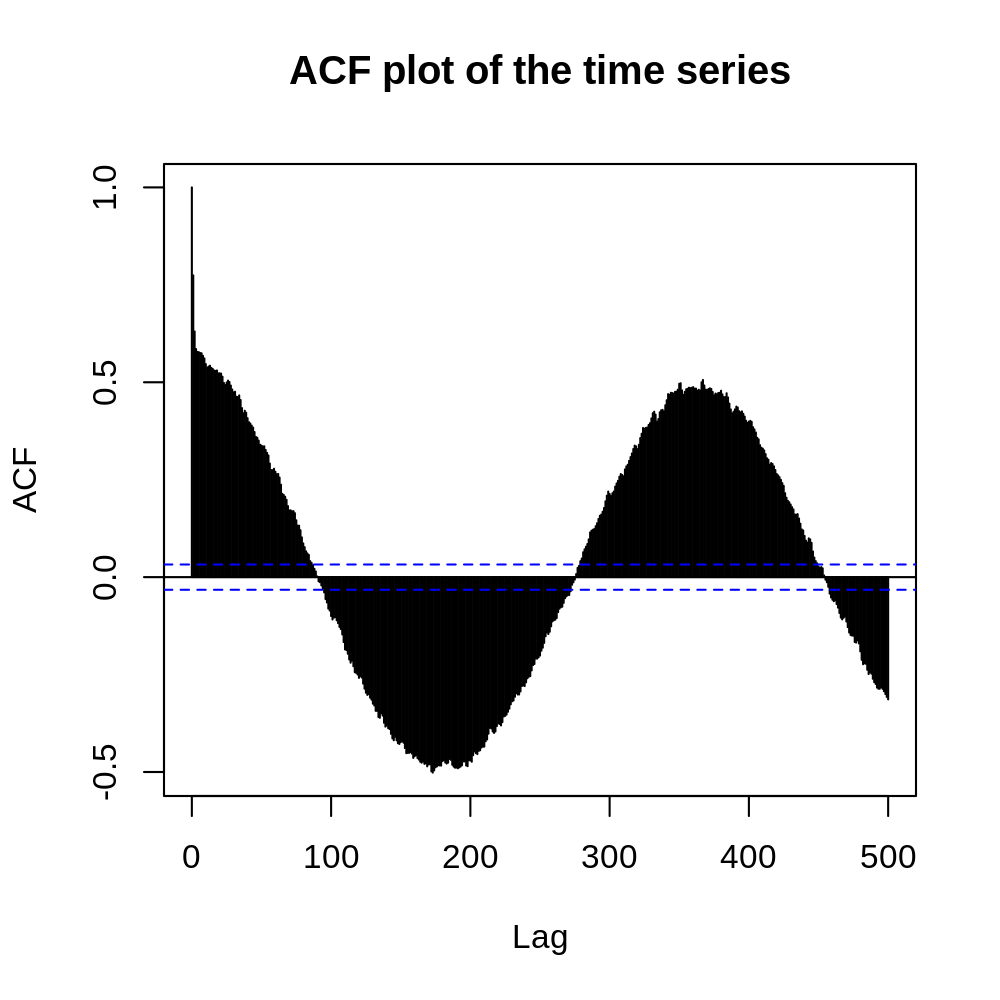

In [4]:
%%R -w 5 -h 5 --units in -r 200
# acf plot of data
acf(temp_data[,2],lag.max=500, main="ACF plot of the time series")

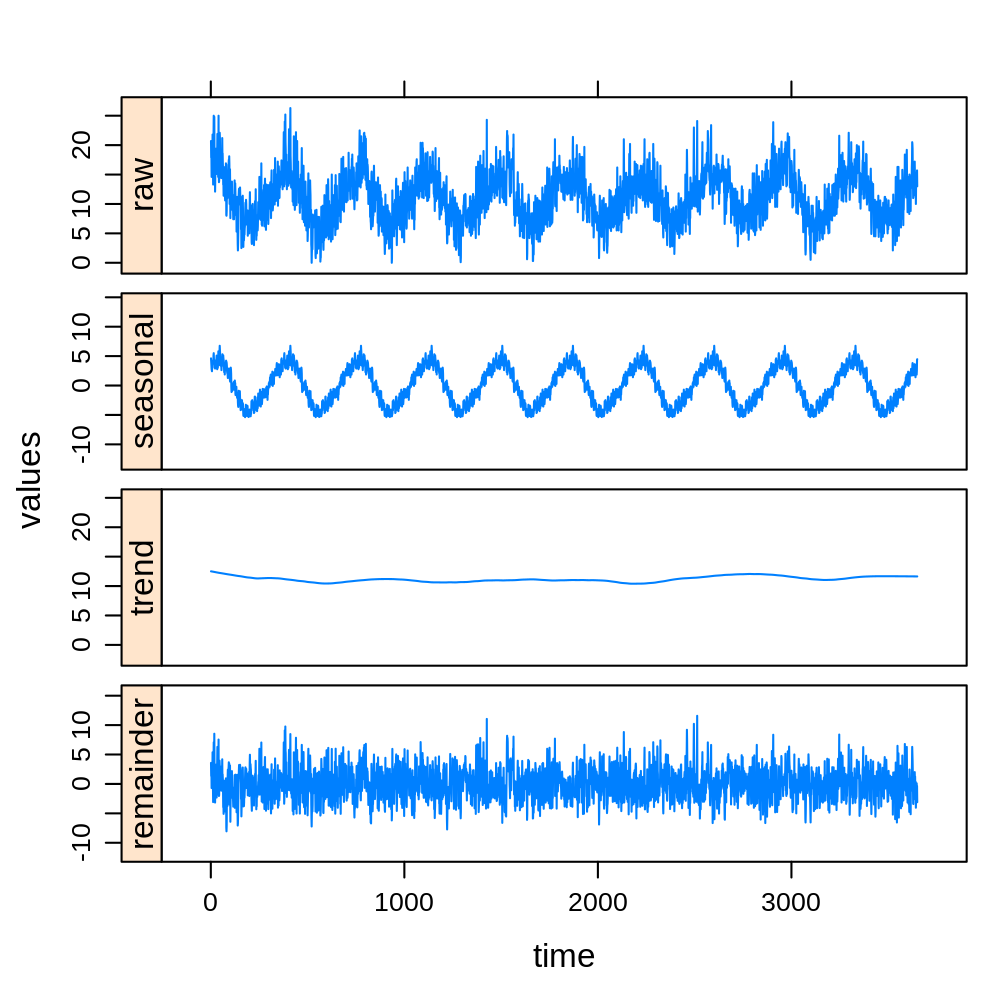

In [5]:
%%R -w 5 -h 5 --units in -r 200
# use stl
stltest <- stlplus(x=temp_data[,2], n.p=365,s.window="periodic",outer=1)
# how does each component look like?
plot(stltest)

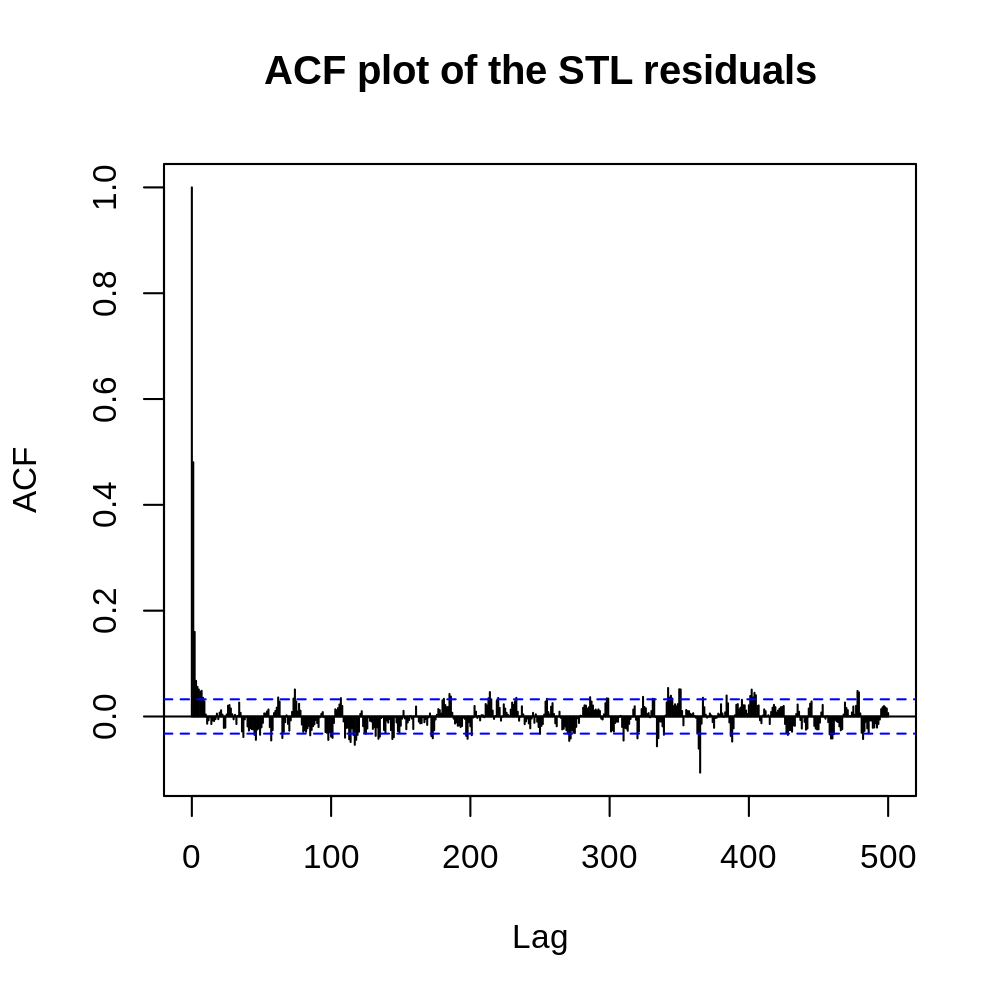

In [6]:
%%R -w 5 -h 5 --units in -r 200
# how does the acf of the remander look like?
acf(stltest$data$remainder,lag.max=500, main="ACF plot of the STL residuals")
# write the remainder to a csv
write.csv(file="data/remainder.csv",x=stltest$data$remainder)

## What about missing time steps?

In [7]:
%%R -w 5 -h 5 --units in -r 200
# load data
temp_data_missing <- read.csv(file="data/daily-minimum-temperatures-in-me_missing.csv", stringsAsFactors=FALSE)

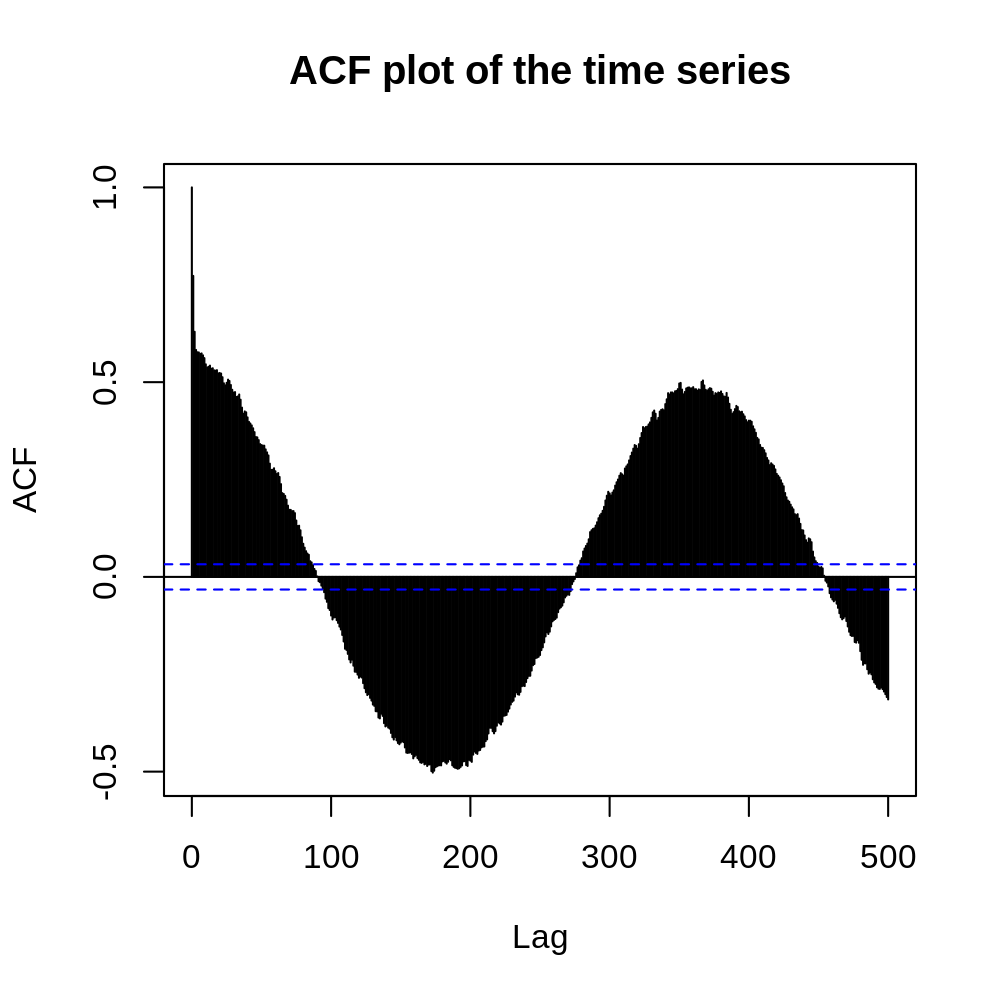

In [8]:
%%R -w 5 -h 5 --units in -r 200
# acf plot of data, will interpolate NA in the ts. 
acf(temp_data_missing[,2],lag.max=500, main="ACF plot of the time series", na.action=na.pass)

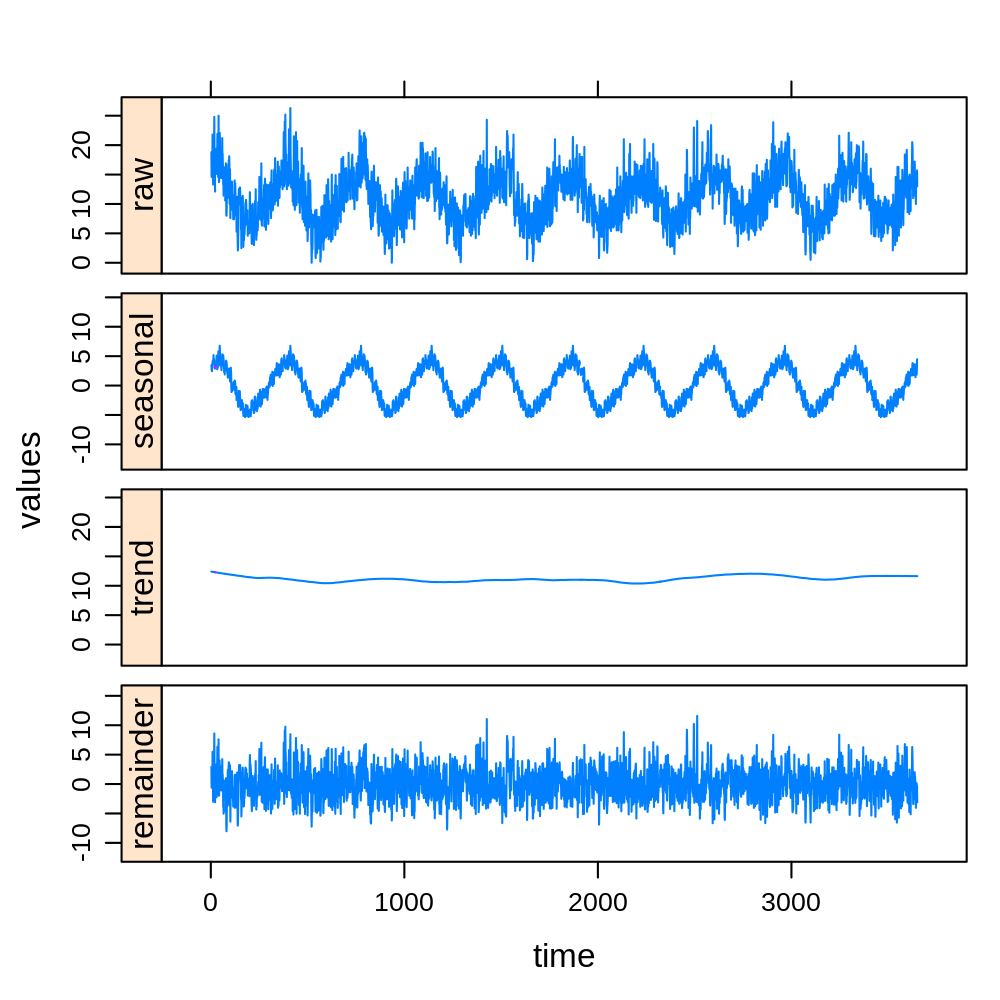

In [9]:
%%R -w 5 -h 5 --units in -r 200
# use stl
stltest <- stlplus(x=temp_data_missing[,2], n.p=365,s.window="periodic",outer=1)
# how does each component look like?
plot(stltest)

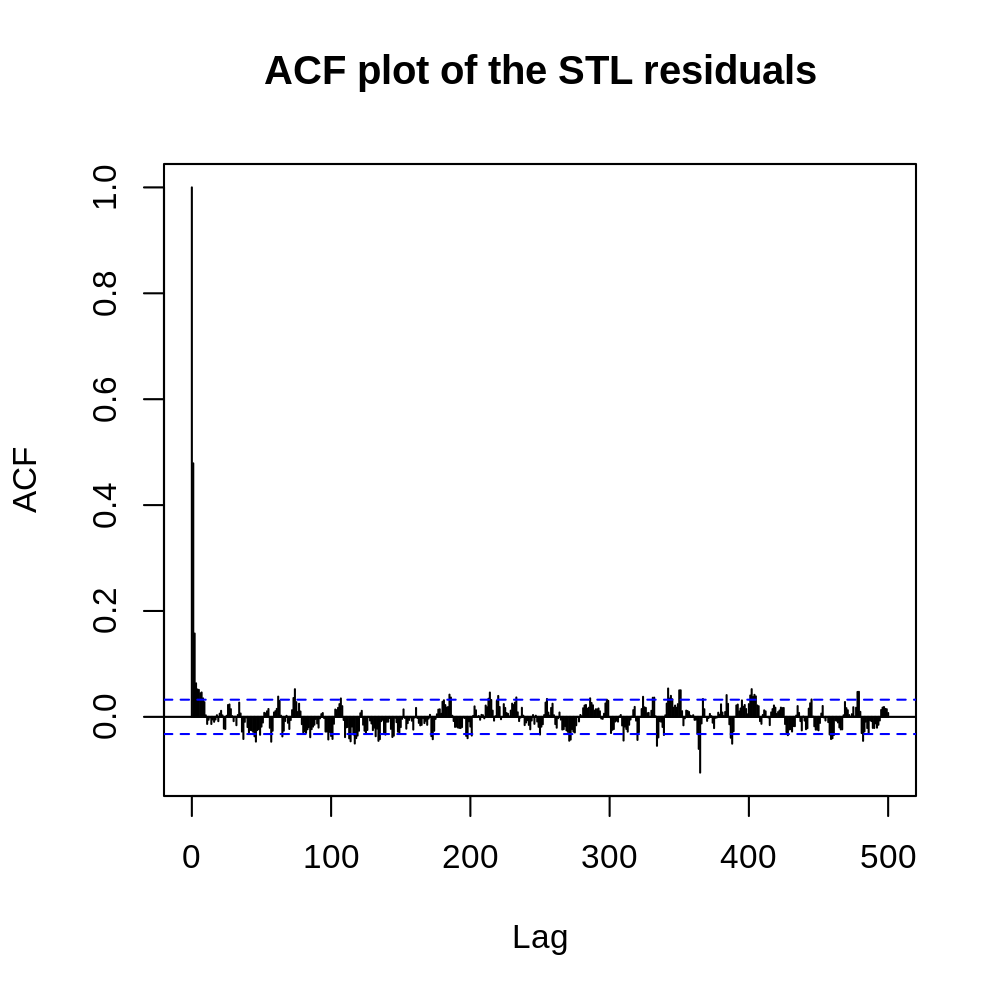

In [10]:
%%R -w 5 -h 5 --units in -r 200
# how does the acf of the remander look like?
acf(stltest$data$remainder,lag.max=500, main="ACF plot of the STL residuals", na.action=na.pass)

In [11]:
%%R -w 5 -h 5 --units in -r 200
# the remainder will still have missing time steps tho!
head(stltest$data)

   raw seasonal    trend  remainder weights  sub.labels
1 20.7 4.629259 12.41578  3.6549640       1 subseries 1
2   NA 3.895674 12.41091         NA       1 subseries 2
3 18.8 3.469671 12.40596  2.9243736       1 subseries 3
4 14.6 2.819855 12.40092 -0.6207717       1 subseries 4
5 15.8 2.630024 12.39580  0.7741775       1 subseries 5
6 15.8 2.440180 12.39060  0.9692173       1 subseries 6


# How do we get from STL residuals to an anomaly score?

In [12]:
remainders = pd.read_csv("data/remainder.csv", header=0)
remainders.head()

,Unnamed: 0,x
0,1,3.575472
1,2,1.350651
2,3,2.845936
3,4,-0.698678
4,5,0.696806


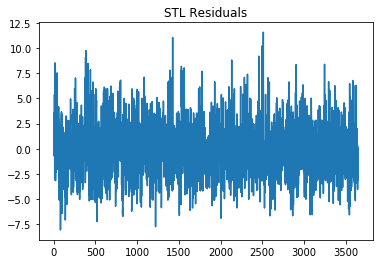

In [13]:
plt.plot(remainders["x"])
plt.title("STL Residuals")
plt.show()

In [14]:
normalized = []
mean = np.mean(remainders["x"].values)
std = np.std(remainders["x"].values)
for item in remainders["x"].values:
    normalized.append((item - mean) / std)

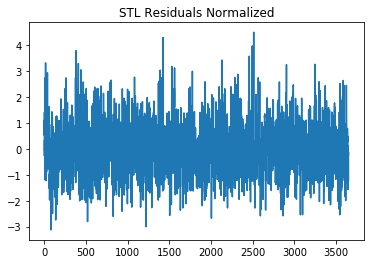

In [15]:
plt.plot(normalized)
plt.title("STL Residuals Normalized")
plt.show()

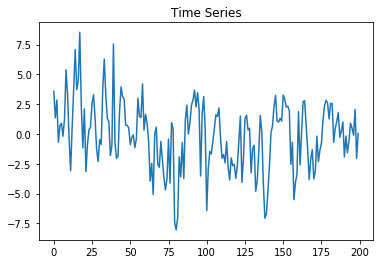

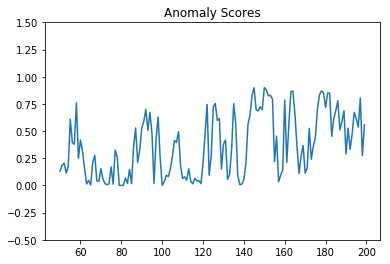

In [16]:
values = list(remainders["x"].values)[0:200]
anomaly_scores = get_anomaly_scores(values=values, window_size=20, step_size=100)

plt.plot(values)
plt.title("Time Series")
plt.show()

plt.plot([i for i in range(50,200)], anomaly_scores[50:])
plt.title("Anomaly Scores")
plt.ylim([-.5,1.5])
plt.show()

# Artificially Inject an Outlier

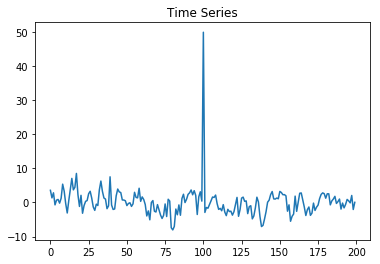

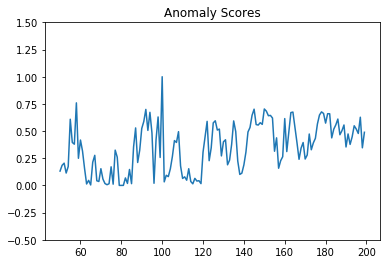

In [17]:
values[100] = 50

anomaly_scores = get_anomaly_scores(values=values, window_size=20, step_size=100)

plt.plot(values)
plt.title("Time Series")
plt.show()

plt.plot([i for i in range(50,200)], anomaly_scores[50:])
plt.title("Anomaly Scores")
plt.ylim([-.5,1.5])
plt.show()

# Tidbits

1) API for R's stlplus:

https://www.rdocumentation.org/packages/stlplus/versions/0.5.1/topics/stlplus

2) Cleveland STL paper:

https://www.wessa.net/download/stl.pdf

3) API for R's ACF:

https://www.rdocumentation.org/packages/forecast/versions/8.5/topics/Acf
